# DATA WRANGLING - ASSIGNMENT 3 

## TASK - 1 DATA INTEGRATION 

## Importing Libraries

- Importing pandas for Data Manipulation
- Importing numpy for mathematical computations
- Importing datetime for date related operations
- Importing DBF for reading .dbf files
- Importing shapefile for reading .shp files
- Importing pycrs
- Importing matplotlib for making plots
- Importing math for mathematical operations

In [145]:
import pandas as pd
import numpy as np
import datetime
from dbfread import DBF
import shapefile
import pycrs
import matplotlib 
from matplotlib.patches import Polygon
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon
from math import sin, cos, sqrt, atan2, radians, asin
from sklearn import preprocessing
from datetime import timedelta

## Reading in the Dataset

Each of us has been given a separate dataset about **housing data** along with a bunch of other files, which we need to integrate with the housing data and get the **desired schema** as our final file output. Let us read in the data and explore it. 

In [146]:
house_df = pd.read_csv('30046572.csv')

In [147]:
house_df.head()

,ID,Address,Rooms,Type,Price,Date,Bathroom,Car,Landsize,Age,Lattitude,Longtitude
0,ID195198670,23 Duffy St,4,h,1180000.0,25/02/2017,3.0,2.0,688.0,59.0,-37.77130,144.89370
1,ID426935414,73 Westbourne Gr,3,h,1550000.0,15/07/2017,2.0,2.0,422.0,69.0,-37.77348,144.99206
2,ID924392942,19 Charles St,3,h,1360000.0,23/09/2017,2.0,1.0,184.0,109.0,-37.77651,144.99074
3,ID781852666,283 Tyler St,3,h,928000.0,18/03/2017,2.0,1.0,0.0,69.0,-37.73070,145.00970
4,ID345928500,8/211 Edwardes St,2,u,336000.0,3/12/2016,1.0,1.0,99.0,49.0,-37.71660,144.99110


We have ID's of the house, addresses, number of rooms and bathrooms and car space along with the coordinates of the house. Seems interesting, but what are we suppossed to do with this data? It only seems logical that we will have to find which **suburb** these houses are in! 

Let us convert the co-ordinates into a tuple!

In [148]:
house_df['long_lat'] = house_df[['Longtitude','Lattitude']].apply(tuple, axis=1)

In [149]:
house_df.head()

,ID,Address,Rooms,Type,Price,Date,Bathroom,Car,Landsize,Age,Lattitude,Longtitude,long_lat
0,ID195198670,23 Duffy St,4,h,1180000.0,25/02/2017,3.0,2.0,688.0,59.0,-37.77130,144.89370,"(144.8937, -37.7713)"
1,ID426935414,73 Westbourne Gr,3,h,1550000.0,15/07/2017,2.0,2.0,422.0,69.0,-37.77348,144.99206,"(144.99206, -37.77348)"
2,ID924392942,19 Charles St,3,h,1360000.0,23/09/2017,2.0,1.0,184.0,109.0,-37.77651,144.99074,"(144.99074, -37.77651)"
3,ID781852666,283 Tyler St,3,h,928000.0,18/03/2017,2.0,1.0,0.0,69.0,-37.73070,145.00970,"(145.0097, -37.7307)"
4,ID345928500,8/211 Edwardes St,2,u,336000.0,3/12/2016,1.0,1.0,99.0,49.0,-37.71660,144.99110,"(144.9911, -37.7166)"


Great! It's a tuple now. Now, let us open the **boundary file** which is in the **.shp** file.

## SUBURB

In [150]:
file_shape = shapefile.Reader("VIC_LOCALITY_POLYGON_shp.shp")

Let's extract each column's information in separate variables and display them so as to see what is in this file.

In [151]:
fields = [x[0] for x in file_shape.fields][1:]
records = file_shape.records()
records = [y[:] for y in file_shape.records()]
shps = [s.points for s in file_shape.shapes()]
shapefile_dataframe = pd.DataFrame(columns = fields, data = records)

In [152]:
shapefile_dataframe.head()

,LC_PLY_PID,DT_CREATE,DT_RETIRE,LOC_PID,VIC_LOCALI,VIC_LOCA_1,VIC_LOCA_2,VIC_LOCA_3,VIC_LOCA_4,VIC_LOCA_5,VIC_LOCA_6,VIC_LOCA_7
0,6670,2011-08-31,None,VIC2615,2012-04-27,None,UNDERBOOL,,,G,None,2
1,6671,2011-08-31,None,VIC1986,2012-04-27,None,NURRAN,,,G,None,2
2,6672,2011-08-31,None,VIC2862,2012-04-27,None,WOORNDOO,,,G,None,2
3,6673,2011-08-31,None,VIC734,2017-08-09,None,DEPTFORD,,,G,None,2
4,6674,2011-08-31,None,VIC2900,2012-04-27,None,YANAC,,,G,None,2


Looks like the column in which we are interested in, **Suburb**, is under the column **VIC_LOCA_2**! We will have to join our **house_df** with this dataframe and extract the suburbs from this.

Giving the **Suburb** column a default value of **not available**.

In [153]:
house_df['Suburb'] = 'not available'

Fot the joining task, we will loop over every value in the **house_df** dataframe and check for a coressponding value in the **shapefile_dataframe**. If it's a match, then the suburb column in the house_df dataframe is imputed with the matched value.

For this task, we will use the **Polygon** function which has been imported from the **shapely** package.

In [154]:
def get_suburb():
    
    for index in shapefile_dataframe.index:
    
        poly_obj = Polygon(shps[index])
    
        for i in range(len(house_df['Lattitude'])):
        
            matching_point = Point(float(house_df['Longtitude'][i]),float(house_df['Lattitude'][i]))
        
            if poly_obj.contains(matching_point) == True:
            
                house_df['Suburb'][i] = shapefile_dataframe['VIC_LOCA_2'][index]

In [155]:
get_suburb()

C:\Users\shiiv\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


Ahaan! That's our first column, in capital letters for some reason. Should we convert it into lower case? Nah, maybe just let it be this way for the time being. 

## OVERPRICED

The house prices in these suburbs are massive! I am not from around here so maybe they come as a shock to me. But are they actually overprices though? We can compare the **median** value of all the houses based on some condition. But which columns can we include for the **aggregation**?

It is not hidden that property prices **change** every year! Sometimes they go up, sometimes they go down but mostly they change every year, maybe not by much, depending on the recession and unemployment rates. So, let us extract the year into a new column!

In [156]:
year_price = []

def get_year():
    
    for years in house_df['Date']:                            
        year_price.append(datetime.datetime.strptime(years, "%d/%m/%Y").strftime('%Y'))

We shall now call the custome year function and make the **year** column in our dataframe.

In [157]:
get_year()

house_df['year'] = year_price

In [158]:
house_df.head()

,ID,Address,Rooms,Type,Price,Date,Bathroom,Car,Landsize,Age,Lattitude,Longtitude,long_lat,Suburb,year
0,ID195198670,23 Duffy St,4,h,1180000.0,25/02/2017,3.0,2.0,688.0,59.0,-37.77130,144.89370,"(144.8937, -37.7713)",MARIBYRNONG,2017
1,ID426935414,73 Westbourne Gr,3,h,1550000.0,15/07/2017,2.0,2.0,422.0,69.0,-37.77348,144.99206,"(144.99206, -37.77348)",NORTHCOTE,2017
2,ID924392942,19 Charles St,3,h,1360000.0,23/09/2017,2.0,1.0,184.0,109.0,-37.77651,144.99074,"(144.99074, -37.77651)",NORTHCOTE,2017
3,ID781852666,283 Tyler St,3,h,928000.0,18/03/2017,2.0,1.0,0.0,69.0,-37.73070,145.00970,"(145.0097, -37.7307)",PRESTON,2017
4,ID345928500,8/211 Edwardes St,2,u,336000.0,3/12/2016,1.0,1.0,99.0,49.0,-37.71660,144.99110,"(144.9911, -37.7166)",RESERVOIR,2016


It's added to our dataframe. We can now define a new column **over_priced?** which will be a boolean with a default value of -1 if the **price of the house is lesses than that of the median price**. 

In [159]:
house_df['over_priced?'] = -1
house_df['median_price'] = np.nan

Getting the **median price** computed in the form of the column **median_price**.

In [160]:
house_df['median_price'].fillna(house_df.groupby(['Rooms','Bathroom','Car','Type','Suburb','year'])["Price"].transform("median"), inplace=True)

We now compare each **price** with the computed **median price** and see that if it is greater, then the **over_priced?** value will be 0. If not, the value will remain -1 as that was the **default** value which we defined at the start of this section.

In [161]:
for i in house_df.index:
    if house_df['Price'][i] > house_df['median_price'][i]:
        house_df['over_priced?'][i] = 0

C:\Users\shiiv\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [162]:
house_df.head()

,ID,Address,Rooms,Type,Price,Date,Bathroom,Car,Landsize,Age,Lattitude,Longtitude,long_lat,Suburb,year,over_priced?,median_price
0,ID195198670,23 Duffy St,4,h,1180000.0,25/02/2017,3.0,2.0,688.0,59.0,-37.77130,144.89370,"(144.8937, -37.7713)",MARIBYRNONG,2017,-1,1180000.0
1,ID426935414,73 Westbourne Gr,3,h,1550000.0,15/07/2017,2.0,2.0,422.0,69.0,-37.77348,144.99206,"(144.99206, -37.77348)",NORTHCOTE,2017,-1,1550000.0
2,ID924392942,19 Charles St,3,h,1360000.0,23/09/2017,2.0,1.0,184.0,109.0,-37.77651,144.99074,"(144.99074, -37.77651)",NORTHCOTE,2017,-1,1360000.0
3,ID781852666,283 Tyler St,3,h,928000.0,18/03/2017,2.0,1.0,0.0,69.0,-37.73070,145.00970,"(145.0097, -37.7307)",PRESTON,2017,-1,928000.0
4,ID345928500,8/211 Edwardes St,2,u,336000.0,3/12/2016,1.0,1.0,99.0,49.0,-37.71660,144.99110,"(144.9911, -37.7166)",RESERVOIR,2016,-1,381750.0


## CRIME

One of the main factors which affect the decision whether we decide to live in a suburb or not is how the **crime ratio** of that suburb is. If the crime ratio is high, people wouldn't want to stay in that place, fearing that something might happen to them. For this attribute, we are required to find the **average crime rate** in the **past 3 years** for **every suburb**. 

We begin by importing the **councils.txt** file 

In [163]:
council = open('councils.txt')
councils_text = []

Defining the **get_councils_text** function to read each line from the text and append it to our **councils_text** list.

In [164]:
def get_councils_text():
    
    for text in council:
        councils_text.append(text)

In [165]:
get_councils_text()

To get the **Local Government Area** of the house, we shall run a loop from our house_df dataframe and for each house in it, map it to a local government area in the councils text file.

In [166]:
house_df['local_govern'] = ''

for iterator_i in house_df.index:
    for iterator_j in councils_text:
        if iterator_j.find(house_df['Suburb'][iterator_i].title()) > 0:
            house_df['local_govern'][iterator_i] = iterator_j.split(":")[0].strip()


C:\Users\shiiv\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [167]:
house_df.head()

,ID,Address,Rooms,Type,Price,Date,Bathroom,Car,Landsize,Age,Lattitude,Longtitude,long_lat,Suburb,year,over_priced?,median_price,local_govern
0,ID195198670,23 Duffy St,4,h,1180000.0,25/02/2017,3.0,2.0,688.0,59.0,-37.77130,144.89370,"(144.8937, -37.7713)",MARIBYRNONG,2017,-1,1180000.0,BAW BAW
1,ID426935414,73 Westbourne Gr,3,h,1550000.0,15/07/2017,2.0,2.0,422.0,69.0,-37.77348,144.99206,"(144.99206, -37.77348)",NORTHCOTE,2017,-1,1550000.0,MURRINDINDI
2,ID924392942,19 Charles St,3,h,1360000.0,23/09/2017,2.0,1.0,184.0,109.0,-37.77651,144.99074,"(144.99074, -37.77651)",NORTHCOTE,2017,-1,1360000.0,MURRINDINDI
3,ID781852666,283 Tyler St,3,h,928000.0,18/03/2017,2.0,1.0,0.0,69.0,-37.73070,145.00970,"(145.0097, -37.7307)",PRESTON,2017,-1,928000.0,BOROONDARA
4,ID345928500,8/211 Edwardes St,2,u,336000.0,3/12/2016,1.0,1.0,99.0,49.0,-37.71660,144.99110,"(144.9911, -37.7166)",RESERVOIR,2016,-1,381750.0,EAST GIPPSLAND


There we have it, now there will be no problem in joining it with the crime dataframe, as it has a **local government area** column as well. 

Let's read in the file and explore it.

In [168]:
file_excel = pd.ExcelFile('crimebylocationdatatable-yearending31march2016.xlsx')
file_excel.sheet_names

['Contents', 'Table 1']

In [169]:
excel_data = file_excel.parse(1)

Oops, looks like the file has a weird format, this will require some cleaning. We will go one by one. The actual file contents seem to start from the **18th row**. So we shall drop everything else. And we will also change the **header** of the file as the 1st row.

In [170]:
excel_data = excel_data.iloc[17:,1:]
col_header = excel_data.iloc[0] 

The first column is empty, nothing useful here. We could just drop that as well and rename the column headers.

In [171]:
excel_data = excel_data[1:] 
excel_data.columns = col_header 

There are only **four columns** that are of use for our analysis. That is, the columns of **year, local government area, crime and crime count**. We will retain only them.

In [172]:
excel_data = excel_data.iloc[:,[0,3,4,6]]

Changing the column names so that it is easier for us to remember them while writing code. Resetting the index as well, almost forgot about it.

In [173]:
excel_data.columns = ['year','local','crime','count']
excel_data.reset_index(drop = True, inplace = True)

In [174]:
excel_data = excel_data.iloc[1:]
excel_data = excel_data.reset_index()

In [175]:
excel_data.head()

,index,year,local,crime,count
0,1,2012,BANYULE,A Crimes against the person,4
1,2,2012,BANYULE,A Crimes against the person,568
2,3,2012,BANYULE,A Crimes against the person,132
3,4,2012,BANYULE,A Crimes against the person,12
4,5,2012,BANYULE,A Crimes against the person,46


Let's start defining different variables needed for our analysis one by one. First is year.

In [176]:
year_data = excel_data['year']

Next is local area government.

In [177]:
local_data = excel_data['local']

Then there is crime.

In [178]:
crime_data = excel_data['crime']

And then there is count.

In [179]:
count_data = excel_data['count']

Getting the **year** and **local government area** from the house_df dataframe.

In [180]:
data_year = house_df['year']
data_local = house_df['local_govern']

In [181]:
def get_crime_average(crime_year, crime_local_govern, crime_type):
    
    crime_total = 0
  
    crime_year_int = int(crime_year)
    
    for i in range(len(year_data)):
        year_int = int(year_data[i])
        
        crime_local_govern_strip = crime_local_govern.strip()
    
        if (((year_int == crime_year_int - 1)|(year_int == crime_year_int - 2)|(year_int == crime_year_int - 3))&(str(local_data[i]) == crime_local_govern_strip)&(crime_type in crime_data[i])):
               crime_total = crime_total + count_data[i]
               
    return (crime_total/3)

Defined above, is a function which **returns the average of crime per suburb for a particular year**. Actually, for a particular year, the **average of past 3 years of crime is returned** by this function.

In [182]:
house_df['crime_A_average'] = -1

for index in house_df.index:
    house_df['crime_A_average'][index] = get_crime_average(crime_year = house_df['year'][index], crime_local_govern = house_df['local_govern'][index], crime_type = 'A Crime')

C:\Users\shiiv\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [183]:
house_df['crime_B_average'] = -1

for index in house_df.index:
    house_df['crime_B_average'][index] = get_crime_average(crime_year = house_df['year'][index], crime_local_govern = house_df['local_govern'][index], crime_type = 'B Property')

C:\Users\shiiv\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [184]:
#house_df["crime_C_average_original"] = house_df.apply(lambda x: get_crime_average(x["year"],x["local_govern"],'C Drug'),axis = 1)

In [185]:
house_df['crime_C_average'] = -1

for index in house_df.index:
    house_df['crime_C_average'][index] = get_crime_average(crime_year = house_df['year'][index], crime_local_govern = house_df['local_govern'][index], crime_type = 'C Drug')

C:\Users\shiiv\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


Above, there are three loops running over the **get_crime_average** function and computes the average crime over three years, with **crime year, crime type and suburb** given as parameters.

In [186]:
house_df.head()

,ID,Address,Rooms,Type,Price,Date,Bathroom,Car,Landsize,Age,...,Longtitude,long_lat,Suburb,year,over_priced?,median_price,local_govern,crime_A_average,crime_B_average,crime_C_average
0,ID195198670,23 Duffy St,4,h,1180000.0,25/02/2017,3.0,2.0,688.0,59.0,...,144.89370,"(144.8937, -37.7713)",MARIBYRNONG,2017,-1,1180000.0,BAW BAW,717,1763,318
1,ID426935414,73 Westbourne Gr,3,h,1550000.0,15/07/2017,2.0,2.0,422.0,69.0,...,144.99206,"(144.99206, -37.77348)",NORTHCOTE,2017,-1,1550000.0,MURRINDINDI,142,344,39
2,ID924392942,19 Charles St,3,h,1360000.0,23/09/2017,2.0,1.0,184.0,109.0,...,144.99074,"(144.99074, -37.77651)",NORTHCOTE,2017,-1,1360000.0,MURRINDINDI,142,344,39
3,ID781852666,283 Tyler St,3,h,928000.0,18/03/2017,2.0,1.0,0.0,69.0,...,145.00970,"(145.0097, -37.7307)",PRESTON,2017,-1,928000.0,BOROONDARA,705,5479,335
4,ID345928500,8/211 Edwardes St,2,u,336000.0,3/12/2016,1.0,1.0,99.0,49.0,...,144.99110,"(144.9911, -37.7166)",RESERVOIR,2016,-1,381750.0,EAST GIPPSLAND,824,1890,159


Crime is done! We can make a better decision of where to get a house now. :)

## Train Station ID and Distance:

Below, we have defined custom functions to get the data from **different files and folders**, such as **calendar, trips, stops dataframe**.  

In [187]:
def get_calendar_dataframe():

    gtfs_list = []
    for i in (1,2,3,4,5,6,7,8,10,11):
        file_path = 'gtfs/' + str(i) + '/google_transit/calendar.txt'
        gtfs_dataframe = pd.read_csv(file_path)
        gtfs_list.append(gtfs_dataframe)
    gtfs_dataframes = pd.concat(gtfs_list)
    gtfs_dataframes = gtfs_dataframes.reset_index()
    return gtfs_dataframes

In [188]:
calendar = get_calendar_dataframe()

In [189]:
calendar_df = calendar[(calendar['monday']== 1) & (calendar['tuesday']== 1) &(calendar['wednesday']== 1) &(calendar['thursday']== 1) &(calendar['friday']== 1) &(calendar['saturday']== 0) &(calendar['sunday']== 0) ]

In [190]:
def get_trips_dataframe():

    gtfs_list = []
    for i in (1,2,3,4,5,6,7,8,10,11):
        file_path = 'gtfs/' + str(i) + '/google_transit/trips.txt'
        gtfs_dataframes = pd.read_csv(file_path)
        gtfs_list.append(gtfs_dataframes)
    gtfs_dataframes = pd.concat(gtfs_list)
    gtfs_dataframes = gtfs_dataframes.reset_index()
    return gtfs_dataframes

In [191]:
trips = get_trips_dataframe()

In [192]:
merged_calendar_trips = pd.DataFrame(pd.merge(calendar_df, trips, on = "service_id", how = "left")['trip_id'])

In [193]:
def get_stops_dataframe():

    gtfs_list = []
    for i in (1,2,3,4,5,6,7,8,10,11):
        file_path = 'gtfs/' + str(i) + '/google_transit/stops.txt'
        gtfs_dataframes = pd.read_csv(file_path)
        gtfs_list.append(gtfs_dataframes)
    gtfs_dataframes = pd.concat(gtfs_list)
    gtfs_dataframes = gtfs_dataframes.reset_index()
    return gtfs_dataframes

In [194]:
stops = get_stops_dataframe()

In [195]:
def get_stop_times_dataframe():

    gtfs_list = []
    for i in (1,2,3,4,5,6,7,8,10,11):
        file_path = 'gtfs/' + str(i) + '/google_transit/stop_times.txt'
        gtfs_dataframes = pd.read_csv(file_path)
        gtfs_list.append(gtfs_dataframes)
    gtfs_dataframes = pd.concat(gtfs_list)
    gtfs_dataframes = gtfs_dataframes.reset_index()
    return gtfs_dataframes

In [196]:
stop_times = get_stop_times_dataframe()

Merging stops and stop_times on **stop_id**.

In [197]:
merged_stop_stop_times = pd.merge(stops,stop_times,on = 'stop_id',how = 'left')

Looping over the merged_stop_stop_times dataframe to get the Southern Cross ID 20043 and 22180.

In [198]:
trip_ids = []
for i,j in enumerate(merged_stop_stop_times.itertuples()):
    if j.stop_id == 20043 or j.stop_id == 22180:
        trip_ids.append(j.trip_id)
        

Below are some operations done to merge and based on **trip id, departure time** conditions.

In [199]:
trips_ids = pd.DataFrame(trip_ids)
trips_ids.columns = ['trip_id']

In [200]:
trips_ids = trips_ids.drop_duplicates()

In [201]:
merged_trips_calendar = trips_ids.merge(merged_calendar_trips, on = 'trip_id', how = 'inner')

In [202]:
merged_stop_stop_times_trips_calendar = pd.merge(merged_stop_stop_times, merged_trips_calendar, on = 'trip_id', how = 'right')

In [203]:
merged_stop_stop_times_trips_calendar = merged_stop_stop_times_trips_calendar[(merged_stop_stop_times_trips_calendar['departure_time'] >= '07:00:00') & (merged_stop_stop_times_trips_calendar['departure_time'] <= '09:30:00')]

In [204]:
merged_stop_stop_times_trips_calendar_copy = merged_stop_stop_times_trips_calendar.copy()

In [205]:
merged_stop_stop_times_trips_calendar.drop_duplicates() #inplace = True was added here

,index_x,stop_id,stop_name,stop_lat,stop_lon,index_y,trip_id,arrival_time,departure_time,stop_sequence,stop_headsign,pickup_type,drop_off_type,shape_dist_traveled
155,7,20043,Southern Cross Railway Station (Melbourne City),-37.818334,144.952525,34841,891.T0.1-V40-G-mjp-1.1.H,07:23:00,07:23:00,13,NaN,0,0,98604.593198
163,85,22239,North Melbourne Railway Station (West Melbourne),-37.806310,144.941510,34840,891.T0.1-V40-G-mjp-1.1.H,07:16:00,07:16:00,12,NaN,1,0,96938.521221
164,95,22253,Essendon Railway Station (Essendon),-37.756012,144.916198,34839,891.T0.1-V40-G-mjp-1.1.H,07:05:00,07:05:00,11,NaN,1,0,90724.944089
173,602,22239,North Melbourne Railway Station (West Melbourne),-37.806310,144.941510,34840,891.T0.1-V40-G-mjp-1.1.H,07:16:00,07:16:00,12,NaN,1,0,96938.521221
175,0,20043,Southern Cross Railway Station (Melbourne City),-37.818334,144.952525,34841,891.T0.1-V40-G-mjp-1.1.H,07:23:00,07:23:00,13,NaN,0,0,98604.593198
308,0,17204,Wallan Railway Station (Wallan),-37.416861,145.005372,34848,892.T0.1-V40-G-mjp-1.1.H,07:37:00,07:37:00,7,NaN,0,0,51201.089571
309,7,20043,Southern Cross Railway Station (Melbourne City),-37.818334,144.952525,34853,892.T0.1-V40-G-mjp-1.1.H,08:36:00,08:36:00,13,NaN,0,0,98604.593198
310,19,20298,Broadford Railway Station (Broadford),-37.207200,145.043008,34844,892.T0.1-V40-G-mjp-1.1.H,07:13:00,07:13:00,3,NaN,0,0,23455.505584
311,28,20307,Donnybrook Railway Station (Donnybrook),-37.542590,144.969860,34849,892.T0.1-V40-G-mjp-1.1.H,07:47:00,07:48:00,8,NaN,0,0,65587.460083
312,37,20316,Heathcote Junction Railway Station (Heathcote ...,-37.367734,145.026310,34847,892.T0.1-V40-G-mjp-1.1.H,07:31:00,07:31:00,6,NaN,0,0,44832.693988


In [206]:
len(merged_stop_stop_times_trips_calendar)

66232

In [207]:
merged_stop_stop_times_trips_calendar.reset_index()

,index,index_x,stop_id,stop_name,stop_lat,stop_lon,index_y,trip_id,arrival_time,departure_time,stop_sequence,stop_headsign,pickup_type,drop_off_type,shape_dist_traveled
0,155,7,20043,Southern Cross Railway Station (Melbourne City),-37.818334,144.952525,34841,891.T0.1-V40-G-mjp-1.1.H,07:23:00,07:23:00,13,NaN,0,0,98604.593198
1,163,85,22239,North Melbourne Railway Station (West Melbourne),-37.806310,144.941510,34840,891.T0.1-V40-G-mjp-1.1.H,07:16:00,07:16:00,12,NaN,1,0,96938.521221
2,164,95,22253,Essendon Railway Station (Essendon),-37.756012,144.916198,34839,891.T0.1-V40-G-mjp-1.1.H,07:05:00,07:05:00,11,NaN,1,0,90724.944089
3,173,602,22239,North Melbourne Railway Station (West Melbourne),-37.806310,144.941510,34840,891.T0.1-V40-G-mjp-1.1.H,07:16:00,07:16:00,12,NaN,1,0,96938.521221
4,175,0,20043,Southern Cross Railway Station (Melbourne City),-37.818334,144.952525,34841,891.T0.1-V40-G-mjp-1.1.H,07:23:00,07:23:00,13,NaN,0,0,98604.593198
5,177,7,20043,Southern Cross Railway Station (Melbourne City),-37.818334,144.952525,34841,891.T0.1-V40-G-mjp-1.1.H,07:23:00,07:23:00,13,NaN,0,0,98604.593198
6,185,85,22239,North Melbourne Railway Station (West Melbourne),-37.806310,144.941510,34840,891.T0.1-V40-G-mjp-1.1.H,07:16:00,07:16:00,12,NaN,1,0,96938.521221
7,186,95,22253,Essendon Railway Station (Essendon),-37.756012,144.916198,34839,891.T0.1-V40-G-mjp-1.1.H,07:05:00,07:05:00,11,NaN,1,0,90724.944089
8,195,602,22239,North Melbourne Railway Station (West Melbourne),-37.806310,144.941510,34840,891.T0.1-V40-G-mjp-1.1.H,07:16:00,07:16:00,12,NaN,1,0,96938.521221
9,197,0,20043,Southern Cross Railway Station (Melbourne City),-37.818334,144.952525,34841,891.T0.1-V40-G-mjp-1.1.H,07:23:00,07:23:00,13,NaN,0,0,98604.593198


In [208]:
list_unique_trips = merged_stop_stop_times_trips_calendar_copy['trip_id'].drop_duplicates()

In [209]:
set_unique_trips = set(list_unique_trips)

In [210]:
merged_stop_stop_times_trips_calendar_copy_new = merged_stop_stop_times_trips_calendar_copy[(merged_stop_stop_times_trips_calendar_copy['stop_id'] == 20043) | (merged_stop_stop_times_trips_calendar_copy['stop_id'] == 22180)]

In [211]:
merged_stop_stop_times_trips_calendar_copy_new = merged_stop_stop_times_trips_calendar_copy_new[['trip_id','stop_id']].drop_duplicates()

In [212]:
stop_ids =[]
for i in merged_stop_stop_times_trips_calendar_copy_new.index:
    stop_ids.append(i)

In [213]:
list_of_unique_trips = list(set_unique_trips)

Converting set_unique_trips into a set and storing it in list_of_unique_trips.

In [214]:
df_stop = pd.DataFrame()

In [215]:
for i in stop_ids:
    trips_id = list_of_unique_trips[stop_ids.index(i)]
    df_stop = pd.concat([df_stop,merged_stop_stop_times_trips_calendar_copy[merged_stop_stop_times_trips_calendar_copy['trip_id']==trips_id].iloc[:i+1]])

In [216]:
df_stop=df_stop.drop_duplicates()

In [217]:
df_stop.reset_index()

,index,index_x,stop_id,stop_name,stop_lat,stop_lon,index_y,trip_id,arrival_time,departure_time,stop_sequence,stop_headsign,pickup_type,drop_off_type,shape_dist_traveled
0,224788,16,19841,Flagstaff Railway Station (Melbourne City),-37.811981,144.955654,265241,9425.T0.2-LIL-F-mjp-1.41.R,08:11:00,08:11:00,18,NaN,0,0,19007.667002
1,224789,17,19842,Melbourne Central Railway Station (Melbourne C...,-37.809939,144.962594,265240,9425.T0.2-LIL-F-mjp-1.41.R,08:09:00,08:09:00,17,NaN,0,0,18350.855005
2,224790,18,19843,Parliament Railway Station (Melbourne City),-37.811054,144.972911,265239,9425.T0.2-LIL-F-mjp-1.41.R,08:07:00,08:07:00,16,NaN,0,0,17201.968503
3,224791,28,19853,Camberwell Railway Station (Camberwell),-37.826567,145.058697,265233,9425.T0.2-LIL-F-mjp-1.41.R,07:53:00,07:53:00,9,NaN,0,0,8459.281590
4,224792,29,19854,Flinders Street Railway Station (Melbourne City),-37.818305,144.966964,265243,9425.T0.2-LIL-F-mjp-1.41.R,08:18:00,08:18:00,20,NaN,0,0,21667.765279
5,224793,67,19892,East Camberwell Railway Station (Camberwell),-37.825894,145.068190,265232,9425.T0.2-LIL-F-mjp-1.41.R,07:51:00,07:51:00,8,NaN,0,0,7616.375521
6,224794,68,19893,Canterbury Railway Station (Canterbury),-37.824485,145.081224,265231,9425.T0.2-LIL-F-mjp-1.41.R,07:49:00,07:49:00,7,NaN,0,0,6423.959747
7,224795,69,19894,Chatham Railway Station (Surrey Hills),-37.824300,145.088648,265230,9425.T0.2-LIL-F-mjp-1.41.R,07:47:00,07:47:00,6,NaN,0,0,5741.274536
8,224796,70,19895,Surrey Hills Railway Station (Surrey Hills),-37.824148,145.098775,265229,9425.T0.2-LIL-F-mjp-1.41.R,07:45:00,07:45:00,5,NaN,0,0,4826.887516
9,224797,71,19896,Mont Albert Railway Station (Mont Albert),-37.819427,145.105530,265228,9425.T0.2-LIL-F-mjp-1.41.R,07:44:00,07:44:00,4,NaN,0,0,4031.024145


Now, will make two new columns in our house_df dataframe **train_station_id, distance_to_train_station**.

In [218]:
house_df['train_station_id'] = 0
house_df['distance_to_train_station'] = 0

radiusOfEarth = 6378
df_stop = df_stop.reset_index() 

**Haversine function** defined below will return the **straight line distance** between two set of coordinates.

Giving the initial and final set of Latitudes and Longitudes, we can loop over our df_stop dataframe and calculate the distances using the **math** libraries **radians, cos, and sin** functions. 

In [219]:
for index in house_df.index:              
               
    lattitude_initial = radians(float(house_df['Lattitude'][index]))
    longtitude_initial = radians(float(house_df['Longtitude'][index]))
               
    minDist = []           
    
    for i in df_stop.index:      
               
            lattitude_final = radians(float(df_stop['stop_lat'][i]))
            longtitude_final = radians(float(df_stop['stop_lon'][i]))
                          
            Longtitude_diff = longtitude_final - longtitude_initial
            Lattitude_diff = lattitude_final - lattitude_initial

            dist_val = sin(Lattitude_diff / 2)**2 + cos(lattitude_initial) * cos(lattitude_final) * sin(Longtitude_diff / 2)**2
            dist_val_final = 2 * atan2(sqrt(dist_val), sqrt(1 - dist_val))
               
            dist = (radiusOfEarth * dist_val_final)
            dist = round((dist) * 1000)
               
            minDist.append(dist)
            
    minDist_1 = min(minDist)
    minDist_final = minDist.index(minDist_1)
    minDist_final_index = df_stop["stop_id"][minDist_final]
    
    house_df["train_station_id"][index] = minDist_final_index
    house_df["distance_to_train_station"][index] = minDist_1

C:\Users\shiiv\Anaconda3\lib\site-packages\ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\shiiv\Anaconda3\lib\site-packages\ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [220]:
house_df[['Lattitude', 'Longtitude', 'distance_to_train_station', 'Suburb', 'train_station_id']].head(n = 10)

,Lattitude,Longtitude,distance_to_train_station,Suburb,train_station_id
0,-37.77130,144.89370,2325,MARIBYRNONG,20038
1,-37.77348,144.99206,492,NORTHCOTE,20016
2,-37.77651,144.99074,246,NORTHCOTE,20017
3,-37.73070,145.00970,661,PRESTON,20011
4,-37.71660,144.99110,1400,RESERVOIR,20010
5,-37.94120,145.04910,1024,MOORABBIN,19872
6,-37.80029,144.87859,616,WEST FOOTSCRAY,20023
7,-37.78203,145.01508,356,FAIRFIELD,19930
8,-37.82270,144.88270,928,YARRAVILLE,19995
9,-37.94350,145.05220,1060,MOORABBIN,19872


Great, distance is done as well. On we move to **Travel Time**!

## Travel Time to CBD

In [221]:
df_stop.head()

,index,index_x,stop_id,stop_name,stop_lat,stop_lon,index_y,trip_id,arrival_time,departure_time,stop_sequence,stop_headsign,pickup_type,drop_off_type,shape_dist_traveled
0,224788,16,19841,Flagstaff Railway Station (Melbourne City),-37.811981,144.955654,265241,9425.T0.2-LIL-F-mjp-1.41.R,08:11:00,08:11:00,18,NaN,0,0,19007.667002
1,224789,17,19842,Melbourne Central Railway Station (Melbourne C...,-37.809939,144.962594,265240,9425.T0.2-LIL-F-mjp-1.41.R,08:09:00,08:09:00,17,NaN,0,0,18350.855005
2,224790,18,19843,Parliament Railway Station (Melbourne City),-37.811054,144.972911,265239,9425.T0.2-LIL-F-mjp-1.41.R,08:07:00,08:07:00,16,NaN,0,0,17201.968503
3,224791,28,19853,Camberwell Railway Station (Camberwell),-37.826567,145.058697,265233,9425.T0.2-LIL-F-mjp-1.41.R,07:53:00,07:53:00,9,NaN,0,0,8459.281590
4,224792,29,19854,Flinders Street Railway Station (Melbourne City),-37.818305,144.966964,265243,9425.T0.2-LIL-F-mjp-1.41.R,08:18:00,08:18:00,20,NaN,0,0,21667.765279


Lots of unwanted columns here. They will cause a problem when we combine or do some computations with them. Let's drop them.

In [222]:
df_stop.drop(['index_x', 'index_y', 'stop_sequence','stop_headsign','pickup_type','drop_off_type','shape_dist_traveled'],axis = 1, inplace = True)

Converting **departure_time, arrival_time** to **time** datatype.

In [223]:
df_stop['departure_time'] = pd.to_timedelta(df_stop['departure_time'])
df_stop['arrival_time'] = pd.to_timedelta(df_stop['arrival_time'])

Resetting the index and dropiing the duplicates.

In [224]:
df_stop.drop(['index'], axis=1, inplace = True)
df_stop.drop_duplicates(inplace = True)

In [225]:
df_stop.head()

,stop_id,stop_name,stop_lat,stop_lon,trip_id,arrival_time,departure_time
0,19841,Flagstaff Railway Station (Melbourne City),-37.811981,144.955654,9425.T0.2-LIL-F-mjp-1.41.R,08:11:00,08:11:00
1,19842,Melbourne Central Railway Station (Melbourne C...,-37.809939,144.962594,9425.T0.2-LIL-F-mjp-1.41.R,08:09:00,08:09:00
2,19843,Parliament Railway Station (Melbourne City),-37.811054,144.972911,9425.T0.2-LIL-F-mjp-1.41.R,08:07:00,08:07:00
3,19853,Camberwell Railway Station (Camberwell),-37.826567,145.058697,9425.T0.2-LIL-F-mjp-1.41.R,07:53:00,07:53:00
4,19854,Flinders Street Railway Station (Melbourne City),-37.818305,144.966964,9425.T0.2-LIL-F-mjp-1.41.R,08:18:00,08:18:00


In [226]:
df_stop.groupby('trip_id').diff()
pd1 = pd.DataFrame(df_stop[(df_stop['stop_id']==20043)|((df_stop['stop_id']==22180))].groupby('trip_id')['arrival_time'])
pd2 = pd.DataFrame()
pd1[1]
for i,j in enumerate(pd1.iterrows()):
    pd2 = pd.concat([pd2,pd1[1][i]])

Grouping the dataframe by **trip id and arrival time** for the Southern Cross ID's.

In [227]:
pd1.head()

,0,1
0,10.T0.2-FKN-F-mjp-1.4.H,"475 08:42:00 Name: arrival_time, dtype: time..."
1,1080.T0.1-V12-G-mjp-1.2.H,"3869 07:00:00 Name: arrival_time, dtype: tim..."
2,1081.T0.1-V12-G-mjp-1.3.H,"2974 07:19:00 Name: arrival_time, dtype: tim..."
3,1083.T0.1-V12-G-mjp-1.5.H,"2178 08:24:00 Name: arrival_time, dtype: tim..."
4,1095.T0.1-V12-G-mjp-1.4.H,"1176 09:08:00 Name: arrival_time, dtype: tim..."


In [228]:
pd2.reset_index(inplace=True)
pd3 = pd.DataFrame(pd1[0])
pd4 = pd.concat([pd3,pd2], axis=1)

Resetting the index and concatinating the two dataframes pd3 and pd4.

In [229]:
pd4.columns = ['trip_id', 'index', 'arrival_time']

In [230]:
pd4.head()

,trip_id,index,arrival_time
0,10.T0.2-FKN-F-mjp-1.4.H,475,08:42:00
1,1080.T0.1-V12-G-mjp-1.2.H,3869,07:00:00
2,1081.T0.1-V12-G-mjp-1.3.H,2974,07:19:00
3,1083.T0.1-V12-G-mjp-1.5.H,2178,08:24:00
4,1095.T0.1-V12-G-mjp-1.4.H,1176,09:08:00


In [231]:
df_stop['arrivalDiff'] = pd.NaT
df_stop['arrivalDiff'] = pd.to_datetime(df_stop['arrivalDiff'])

In [232]:
listStop = []
for i,j in pd4.iterrows():
    if j.trip_id not in listStop:
        df_stop.loc[:,'arrivalDiff'][(df_stop['trip_id'] == j.trip_id)] = df_stop.loc[:,'arrival_time'][(df_stop['trip_id'] == j.trip_id)].values - j.arrival_time
    listStop.append(j.trip_id)

C:\Users\shiiv\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [233]:
df_stop.arrivalDiff.head()

0   -1 days +23:58:00
1   -1 days +23:56:00
2   -1 days +23:54:00
3   -1 days +23:40:00
4            00:05:00
Name: arrivalDiff, dtype: timedelta64[ns]

Converting the **travel time to minutes and storing it in a dictionary, stopidDict**.

In [234]:
import math
stopidDict = {}
for index,row in df_stop.iterrows():
    if math.isnan(row.arrivalDiff.seconds):
        continue
    else:
        if row.arrivalDiff.seconds >=1440:
            continue
        else:
            if row.stop_id not in stopidDict.keys():
                stopidDict[row.stop_id] = row.arrivalDiff.seconds//60
            else:
                stopidDict[row.stop_id] = np.mean([stopidDict[row.stop_id],row.arrivalDiff.seconds//60])

Time to iterate over the house_df and impute **travel time** values one at a time. We first define a new column **travel_min_to_CBD** and give it a default value of 0.

In [235]:
house_df['travel_min_to_CBD'] = 0

In [236]:
for i,j in house_df.iterrows():
    if j.train_station_id in stopidDict.keys():
        house_df.loc[:, 'travel_min_to_CBD'][house_df['train_station_id']==j.train_station_id] = stopidDict[j.train_station_id]
        
house_df[house_df['travel_min_to_CBD'] != 0]

C:\Users\shiiv\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,ID,Address,Rooms,Type,Price,Date,Bathroom,Car,Landsize,Age,...,year,over_priced?,median_price,local_govern,crime_A_average,crime_B_average,crime_C_average,train_station_id,distance_to_train_station,travel_min_to_CBD
0,ID195198670,23 Duffy St,4,h,1180000.0,25/02/2017,3.0,2.0,688.0,59.0,...,2017,-1,1180000.0,BAW BAW,717,1763,318,20038,2325,12.500000
1,ID426935414,73 Westbourne Gr,3,h,1550000.0,15/07/2017,2.0,2.0,422.0,69.0,...,2017,-1,1550000.0,MURRINDINDI,142,344,39,20016,492,22.975586
2,ID924392942,19 Charles St,3,h,1360000.0,23/09/2017,2.0,1.0,184.0,109.0,...,2017,-1,1360000.0,MURRINDINDI,142,344,39,20017,246,21.975586
6,ID171719689,8/102 Cross St,2,u,480000.0,3/06/2017,1.0,1.0,1157.0,99.0,...,2017,-1,480000.0,MOIRA,298,735,154,20023,616,11.000000
8,ID826546296,8 Gordon Pde,3,h,990000.0,6/05/2017,1.0,2.0,340.0,79.0,...,2017,0,931250.0,MITCHELL,817,1779,181,19995,928,15.008789
10,ID776930874,129 Hambleton St,3,h,1630000.0,29/04/2017,1.0,0.0,143.0,119.0,...,2017,-1,1630000.0,BENALLA,313,545,65,19958,2364,20.000000
13,ID404594744,302/34 Union St,2,u,1180000.0,27/11/2016,1.0,1.0,0.0,9.0,...,2016,-1,1180000.0,MITCHELL,703,1502,135,19969,134,12.000000
17,ID194053751,3/40 Rowland St,2,u,891000.0,28/05/2016,1.0,1.0,121.0,10.0,...,2016,-1,891000.0,SOUTH GIPPSLAND,271,771,74,19903,1277,19.750000
18,ID720446462,166 Gordon St,2,h,2100000.0,3/09/2016,1.0,1.0,659.0,99.0,...,2016,-1,2100000.0,HOBSONS BAY,925,4701,308,19893,1680,22.500000
19,ID522119116,305/28 Burnley St,1,u,327000.0,7/11/2016,1.0,1.0,0.0,7.0,...,2016,-1,383000.0,EAST GIPPSLAND,824,1890,159,19977,1508,12.000000


Travel time has been computed successfully. It's time to combine and refine all the required columns and create our solution file.

In [237]:
df_stop[df_stop['stop_id']==j.train_station_id]['arrivalDiff'].mean().seconds//60-1440

-8

In [238]:
for i,j in house_df.iterrows():
    if ((j.train_station_id!=20043)|(j.train_station_id!=221800)):
        meanList = []
        for i in df_stop[df_stop['stop_id']==j.train_station_id]['arrivalDiff']:
            if i.days>=0:
                meanList.append(i.seconds//60)
        house_df.loc[:,'travel_min_to_CBD'][house_df['train_station_id']==j.train_station_id] = np.mean(meanList)

C:\Users\shiiv\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
C:\Users\shiiv\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\shiiv\Anaconda3\lib\site-packages\numpy\core\_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [239]:
house_df.loc[:,'travel_min_to_CBD'][pd.isnull(house_df.iloc[:,-1])] = 0

C:\Users\shiiv\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [240]:
house_df[house_df['train_station_id'] == 22180]

,ID,Address,Rooms,Type,Price,Date,Bathroom,Car,Landsize,Age,...,year,over_priced?,median_price,local_govern,crime_A_average,crime_B_average,crime_C_average,train_station_id,distance_to_train_station,travel_min_to_CBD
55,ID542955178,702/127 Beach St,2,u,1252000.0,24/09/2016,1.0,2.0,0.0,13.0,...,2016,-1,1252000.0,BOROONDARA,659,5219,338,22180,3157,0.0
189,ID130415347,22 Park Sq,3,h,1630000.0,4/03/2017,2.0,2.0,135.0,22.0,...,2017,-1,1630000.0,BOROONDARA,705,5479,335,22180,2833,0.0
350,ID341071781,403/99 Nott St,1,u,455500.0,24/09/2016,1.0,1.0,0.0,17.0,...,2016,-1,455500.0,BOROONDARA,659,5219,338,22180,2756,0.0


In [241]:
house_df[house_df['travel_min_to_CBD']==0]

,ID,Address,Rooms,Type,Price,Date,Bathroom,Car,Landsize,Age,...,year,over_priced?,median_price,local_govern,crime_A_average,crime_B_average,crime_C_average,train_station_id,distance_to_train_station,travel_min_to_CBD
14,ID143752726,74 Bridport St,3,h,2800000.0,30/07/2016,3.0,1.0,0.0,129.0,...,2016,-1,2800000.0,BANYULE,1202,5034,333,20043,2443,0.0
39,ID613312198,8/192 Cecil St,1,u,460000.0,8/04/2017,1.0,1.0,0.0,49.0,...,2017,-1,460000.0,GREATER SHEPPARTON,1245,3886,447,20043,1854,0.0
55,ID542955178,702/127 Beach St,2,u,1252000.0,24/09/2016,1.0,2.0,0.0,13.0,...,2016,-1,1252000.0,BOROONDARA,659,5219,338,22180,3157,0.0
140,ID577819778,46 Osborne Rd,5,h,1550000.0,24/06/2017,3.0,4.0,4221.0,39.0,...,2017,-1,1550000.0,NORTHERN GRAMPIANS,251,768,83,19878,7726,0.0
161,ID547119478,4 Selby Ct,3,h,857000.0,3/09/2017,2.0,1.0,1007.0,39.0,...,2017,-1,857000.0,GOLDEN PLAINS,84,371,13,19877,2730,0.0
189,ID130415347,22 Park Sq,3,h,1630000.0,4/03/2017,2.0,2.0,135.0,22.0,...,2017,-1,1630000.0,BOROONDARA,705,5479,335,22180,2833,0.0
197,ID161359680,96 Avebury Dr,4,h,627500.0,1/07/2017,2.0,2.0,687.0,69.0,...,2017,-1,627500.0,TOWONG,59,124,5,22251,2197,0.0
209,ID552319416,28 Nelson Pl,3,h,2050000.0,6/05/2017,2.0,1.0,230.0,119.0,...,2017,-1,2050000.0,GREATER SHEPPARTON,1245,3886,447,20043,2111,0.0
254,ID875202055,153 Dow St,2,h,1130000.0,22/05/2016,1.0,0.0,112.0,12.0,...,2016,-1,1130000.0,BOROONDARA,659,5219,338,20043,2619,0.0
287,ID343390016,59 Barrett St,3,h,2340000.0,26/08/2017,2.0,1.0,162.0,139.0,...,2017,-1,2340000.0,BANYULE,1214,5603,375,20043,2861,0.0


In [242]:
house_df_final = house_df[['ID', 'Address', 'Suburb', 'Price', 'Type', 'Date', 'Rooms', 'Bathroom', 'Car',
       'Landsize', 'Age', 'Lattitude', 'Longtitude', 'train_station_id', 'distance_to_train_station',
       'travel_min_to_CBD', 'over_priced?', 'crime_A_average',
       'crime_B_average', 'crime_C_average'
        ]]

In [243]:
house_df.columns

Index(['ID', 'Address', 'Rooms', 'Type', 'Price', 'Date', 'Bathroom', 'Car',
       'Landsize', 'Age', 'Lattitude', 'Longtitude', 'long_lat', 'Suburb',
       'year', 'over_priced?', 'median_price', 'local_govern',
       'crime_A_average', 'crime_B_average', 'crime_C_average',
       'train_station_id', 'distance_to_train_station', 'travel_min_to_CBD'],
      dtype='object')

In [244]:
house_df_final.columns = ['ID', 'Address', 'Suburb', 'Price', 'Type', 'Date', 'Rooms', 'Bathroom', 'Car',
       'Landsize', 'Age', 'Latitude', 'Longtitude', 'train_station_id', 'distance_to_train_station',
       'travel_min_to_CBD', 'over_priced?', 'crime_A_average',
       'crime_B_average', 'crime_C_average'
        ]

In [245]:
house_df_final

,ID,Address,Suburb,Price,Type,Date,Rooms,Bathroom,Car,Landsize,Age,Latitude,Longtitude,train_station_id,distance_to_train_station,travel_min_to_CBD,over_priced?,crime_A_average,crime_B_average,crime_C_average
0,ID195198670,23 Duffy St,MARIBYRNONG,1180000.0,h,25/02/2017,4,3.0,2.0,688.0,59.0,-37.77130,144.89370,20038,2325,12.076923,-1,717,1763,318
1,ID426935414,73 Westbourne Gr,NORTHCOTE,1550000.0,h,15/07/2017,3,2.0,2.0,422.0,69.0,-37.77348,144.99206,20016,492,22.727273,-1,142,344,39
2,ID924392942,19 Charles St,NORTHCOTE,1360000.0,h,23/09/2017,3,2.0,1.0,184.0,109.0,-37.77651,144.99074,20017,246,21.727273,-1,142,344,39
3,ID781852666,283 Tyler St,PRESTON,928000.0,h,18/03/2017,3,2.0,1.0,0.0,69.0,-37.73070,145.00970,20011,661,31.600000,-1,705,5479,335
4,ID345928500,8/211 Edwardes St,RESERVOIR,336000.0,u,3/12/2016,2,1.0,1.0,99.0,49.0,-37.71660,144.99110,20010,1400,33.384615,-1,824,1890,159
5,ID317414938,2b Rice St,MOORABBIN,910000.0,t,12/11/2016,3,2.0,2.0,312.0,19.0,-37.94120,145.04910,19872,1024,38.500000,-1,71,261,20
6,ID171719689,8/102 Cross St,WEST FOOTSCRAY,480000.0,u,3/06/2017,2,1.0,1.0,1157.0,99.0,-37.80029,144.87859,20023,616,11.000000,-1,298,735,154
7,ID769666978,1/22 Rathmines St,FAIRFIELD,667000.0,u,17/06/2017,2,1.0,1.0,86.0,10.0,-37.78203,145.01508,19930,356,24.000000,-1,330,1855,82
8,ID826546296,8 Gordon Pde,YARRAVILLE,990000.0,h,6/05/2017,3,1.0,2.0,340.0,79.0,-37.82270,144.88270,19995,928,15.181818,0,817,1779,181
9,ID679739347,118 Rowans Rd,MOORABBIN,901000.0,h,16/07/2016,3,2.0,3.0,558.0,64.0,-37.94350,145.05220,19872,1060,38.500000,-1,71,261,20


In [246]:
house_df_final.to_csv('30046572_solution.csv')

## TASK 2 - DATA RESHAPING

Below are several transformations that are applied to the data. Namely, **Root transformation, Square, Log, Normalization ans Min Max Transformation**.

In [247]:
df_reshaped = house_df[['Rooms','crime_C_average','travel_min_to_CBD','Age','Price']]

## Root Transformation

In [248]:
df_reshaped['price_sqr_root'] = df_reshaped.apply(lambda x: math.sqrt(float(x['Price'])), axis = 1)

C:\Users\shiiv\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


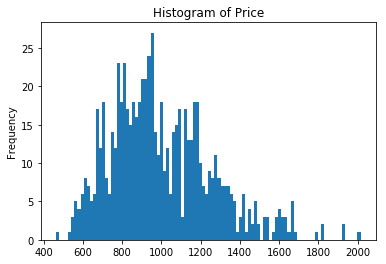

In [249]:
df_reshaped['price_sqr_root'].plot(kind='hist',bins=100,title='Histogram of Price')

## Square Transformation

In [250]:
df_reshaped['price_square'] = df_reshaped.apply(lambda x: math.pow(float(x['Price']), 2), axis = 1)

C:\Users\shiiv\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


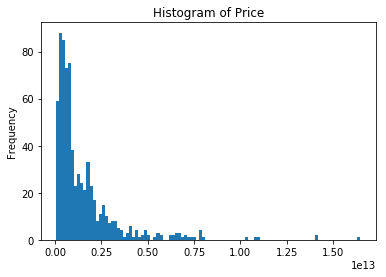

In [251]:
df_reshaped['price_square'].plot(kind='hist',bins=100,title='Histogram of Price')

## Log Transformation

In [252]:
df_reshaped['price_log'] = df_reshaped.apply(lambda x: math.log(float(x['Price'])), axis = 1)

C:\Users\shiiv\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


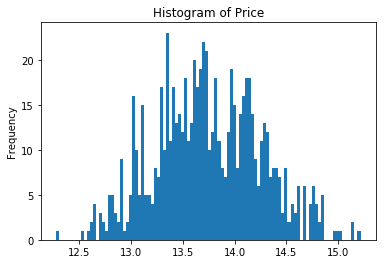

In [253]:
df_reshaped['price_log'].plot(kind='hist',bins=100,title='Histogram of Price')

## Normalization Transformation

In [254]:
std_scale = preprocessing.StandardScaler().fit(df_reshaped[['Price']])
df_std = std_scale.transform(df_reshaped[['Price']]) # an array not a df
df_std

array([[ 1.97723229e-01],
       [ 8.40643984e-01],
       [ 5.10495488e-01],
       [-2.40157934e-01],
       [-1.26883114e+00],
       [-2.71435160e-01],
       [-1.01861334e+00],
       [-6.93677710e-01],
       [-1.32425267e-01],
       [-2.87073773e-01],
       [ 9.79653877e-01],
       [-7.66657904e-01],
       [ 7.71139038e-01],
       [ 1.97723229e-01],
       [ 3.01267356e+00],
       [-6.29203206e-02],
       [-7.23217313e-01],
       [-3.04450010e-01],
       [ 1.79633700e+00],
       [-1.28446976e+00],
       [-1.15675442e+00],
       [-9.76727939e-02],
       [-3.32251988e-01],
       [ 1.80346992e-01],
       [ 7.27698446e-01],
       [-9.41975465e-02],
       [ 3.71485595e-01],
       [-4.79950000e-01],
       [-5.49454946e-01],
       [-8.01410377e-01],
       [-1.00123710e+00],
       [-1.21409600e+00],
       [ 6.52980629e-01],
       [ 4.23614305e-01],
       [ 4.23614305e-01],
       [-4.45197526e-01],
       [ 1.00598732e-02],
       [-1.94797290e-02],
       [-2.8

In [255]:
df_reshaped['priceStandard'] = df_std

C:\Users\shiiv\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


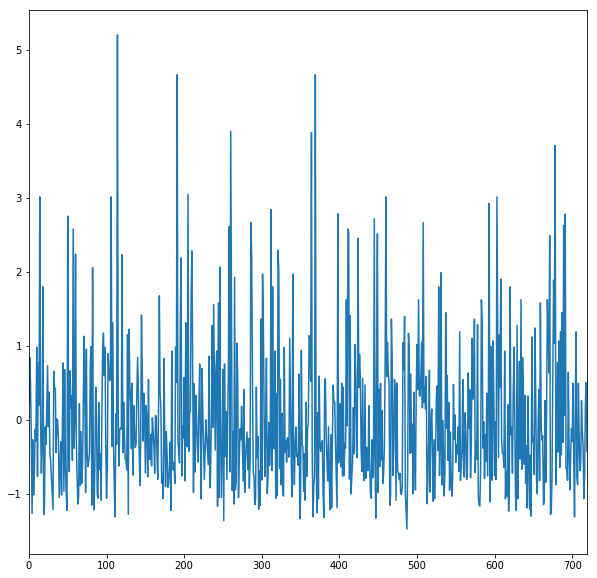

In [256]:
df_reshaped['priceStandard'].plot(figsize=(10,10))

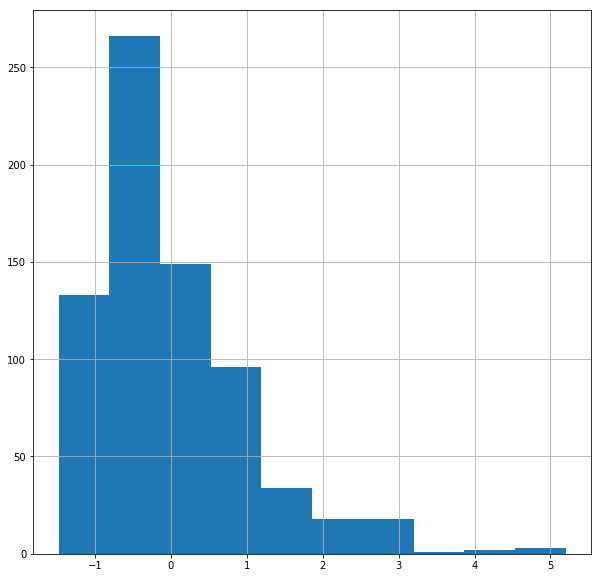

In [257]:
df_reshaped['priceStandard'].hist(figsize=(10,10))

## Min Max Transformation

In [258]:
minmax_scale = preprocessing.MinMaxScaler().fit(df_reshaped[['Price']])
df_minmax = minmax_scale.transform(df_reshaped[['Price']])
df_minmax

array([[0.25097529],
       [0.34720416],
       [0.29778934],
       [0.18543563],
       [0.03146944],
       [0.18075423],
       [0.06892068],
       [0.11755527],
       [0.20156047],
       [0.17841352],
       [0.3680104 ],
       [0.10663199],
       [0.33680104],
       [0.25097529],
       [0.67230169],
       [0.21196359],
       [0.11313394],
       [0.17581274],
       [0.49024707],
       [0.02912874],
       [0.04824447],
       [0.20676203],
       [0.1716515 ],
       [0.24837451],
       [0.33029909],
       [0.20728218],
       [0.27698309],
       [0.14954486],
       [0.13914174],
       [0.10143043],
       [0.07152146],
       [0.0396619 ],
       [0.31911573],
       [0.28478544],
       [0.28478544],
       [0.15474642],
       [0.22288687],
       [0.21846554],
       [0.17815345],
       [0.06371912],
       [0.11703511],
       [0.17685306],
       [0.06892068],
       [0.19115735],
       [0.33628088],
       [0.07672302],
       [0.32249675],
       [0.122

In [259]:
df_reshaped['priceMinMax'] = df_minmax

C:\Users\shiiv\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


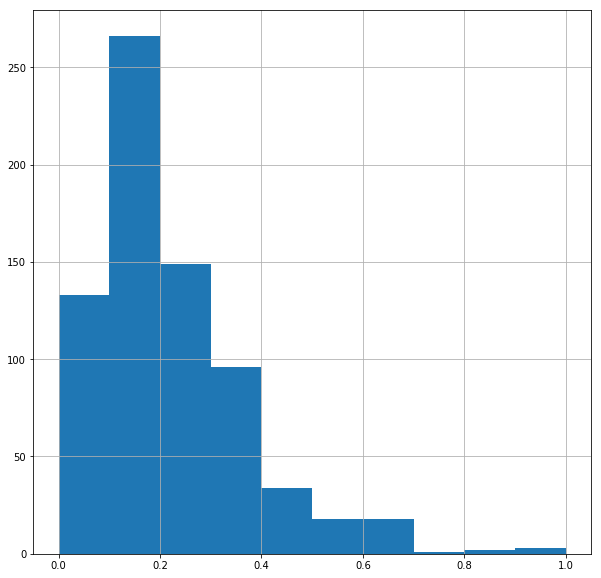

In [260]:
df_reshaped['priceMinMax'].hist(figsize=(10,10))